# Demo and cookbook

In [1]:
import comod
import numpy as np

## Defining a model

In [2]:
model=comod.Model("SIR",  # States
                  "bg",  # Coefficients
                  [  # Rules in the form (origin, destination, coefficient)
                    ("S", "I", "b I / N"), # N is a special state with the total population
                    ("I", "R", "g"),
                  ],
                  # Special state names can be set with the following options:
                  sum_state="N",  # Total population
                  nihil_state="$"  # The nothingness (?) from which one is born and to which one dies
                 )

## Plotting the model

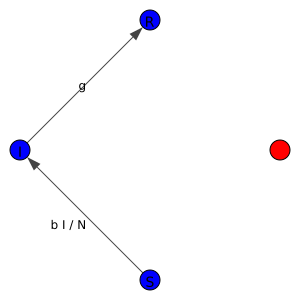

In [3]:
model.plot_graph(layout="circle",bbox=(300,300))

## Output the differential equations in LaTeX

In [4]:
latex=model.to_latex()
print(latex)

\begin{array}{lcl} \dot{S} &=& -b I / N S\\
\dot{I} &=& b I / N S - g I\\
\dot{R} &=& g I 
\end{array}


In [5]:
from IPython.display import display, Math
display(Math(latex))

<IPython.core.display.Math object>

## Solve and plot

In [6]:
t = np.linspace(0, 150, 150)
S, I, R = model.solve((999, 1, 0),  # Initial state
                      [0.3,0.1],  # Coefficient values
                      t  # Time mesh
                     )

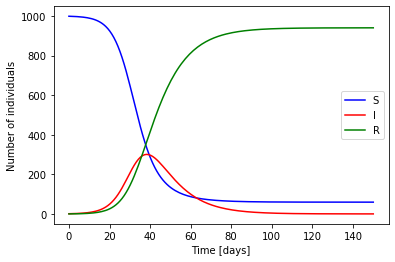

In [7]:
import matplotlib.pyplot as plt
plt.plot(t, S, 'b', label="S")
plt.plot(t, I, 'r', label="I")
plt.plot(t, R, 'g', label="R")
plt.xlabel("Time [days]")
plt.ylabel("Number of individuals")
plt.legend()
plt.show()

### Dynamic solution using ipywidgets

In [8]:
import ipywidgets

In [9]:
@ipywidgets.interact
def plot(beta=ipywidgets.FloatSlider(min=0.0, max=2, value=0.3, description="$\\beta$"),
        gamma=ipywidgets.FloatSlider(min=0.0, max=0.3, value=0.1, step=0.01,description="$\\gamma$")):
    t = np.linspace(0, 150, 150)
    S, I, R = model.solve((999, 1, 0),[beta,gamma] ,t)
    plt.plot(t, S, 'b', label="S")
    plt.plot(t, I, 'r', label="I")
    plt.plot(t, R, 'g', label="R")
    plt.xlabel("Time [days]")
    plt.ylabel("Number of individuals")
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.3, description='$\\beta$', max=2.0), FloatSlider(value=0.1, descript…